# Global Analysis of Acute Food Insecurity (IPC Phase Classification)

## Course
DSCD 611 – Programming for Data Scientists I

Group B11

## Project Overview
This project explores global patterns in acute food insecurity using the Integrated Food Security Phase Classification (IPC) dataset. The IPC framework categorizes populations into five phases of food insecurity, ranging from minimal food insecurity (Phase 1) to catastrophe/famine (Phase 5).

Using time-series and cross-country analysis, this study examines:
- Global trends in food insecurity severity
- Country-level burden and severity
- Regional disparities in Africa
- Depth, volatility, and dynamics of food insecurity
- Recovery versus persistence in crisis situations

The analysis combines descriptive statistics, visualization, and inferential methods to provide policy-relevant insights.


## Research Questions

1. How has the global average percentage of the population in Crisis or worse (IPC Phase ≥ 3) changed over time?
2. Which countries contribute the largest share of the global population in Phase 3+?
3. Which five countries currently have the highest percentage of their population in Phase 3+?
4. How does food insecurity in West Africa compare to East Africa?
5. Among countries in Phase 3+, which experience the deepest crises (higher shares in Phases 4–5)?
6. Which countries are experiencing the fastest deterioration in food insecurity severity?
7. Is higher food insecurity severity associated with greater volatility?
8. Which countries show evidence of recovery versus persistent crisis?


## Data Source

The dataset used in this project is:

- **IPC_IPC_PHASE.csv**
- Source: Integrated Food Security Phase Classification (IPC)
- Temporal coverage: Monthly observations
- Units:
  - `PS`: Number of people
  - `PT`: Percentage of population

Each observation represents the population classified into a specific IPC phase for a given country and month.


In [1]:
# Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, pearsonr
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["font.size"] = 12

## Data Loading

The dataset is loaded from a local directory. The file path may need to be updated depending on the user’s system.


In [2]:
## Load Data

file_path = r"C:\Users\GIDI\Desktop\MSC DATA SCIENCE\FIRST SEMESTER\DSCD 601 Programming for Data Scientists I\Project\Datasets\raw\IPC_IPC_PHASE.csv"
df_raw = pd.read_csv(file_path)

print("Raw data shape:", df_raw.shape)
df_raw.head()


Raw data shape: (4860, 37)


,STRUCTURE,STRUCTURE_ID,ACTION,FREQ,FREQ_LABEL,REF_AREA,REF_AREA_LABEL,INDICATOR,INDICATOR_LABEL,SEX,...,UNIT_MULT,UNIT_MULT_LABEL,UNIT_TYPE,UNIT_TYPE_LABEL,TIME_FORMAT,TIME_FORMAT_LABEL,OBS_STATUS,OBS_STATUS_LABEL,OBS_CONF,OBS_CONF_LABEL
0,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,BDI,Burundi,IPC_IPC_PHASE,People in each phase of food insecurity classi...,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
1,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,CAF,Central African Republic,IPC_IPC_PHASE,People in each phase of food insecurity classi...,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
2,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,GTM,Guatemala,IPC_IPC_PHASE,People in each phase of food insecurity classi...,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
3,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,HTI,Haiti,IPC_IPC_PHASE,People in each phase of food insecurity classi...,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public
4,datastructure,WB.DATA360:DS_DATA360(1.2),I,M,Monthly,SWZ,Eswatini,IPC_IPC_PHASE,People in each phase of food insecurity classi...,_T,...,0,Units,COUNT,Count (Integer),610,CCYYMM,A,Normal value,PU,Public


## Data Cleaning and Preparation

Key preprocessing steps include:
- Converting time periods into datetime format
- Extracting IPC phase numbers
- Selecting and renaming relevant columns
- Removing missing or invalid observations


In [3]:
# Cleaning

df_raw["date"] = pd.to_datetime(df_raw["TIME_PERIOD"], format="%Y-%m", errors="coerce")
df_raw["phase"] = df_raw["COMP_BREAKDOWN_2"].str.extract(r"PHASE(\d)").astype(float)

df = df_raw.rename(columns={
    "REF_AREA": "iso3",
    "REF_AREA_LABEL": "country",
    "UNIT_MEASURE": "unit",
    "OBS_VALUE": "value"
})[["iso3", "country", "date", "phase", "unit", "value"]]

df = df.dropna(subset=["date", "phase", "value"])
df["phase"] = df["phase"].astype(int)

df.head()


,iso3,country,date,phase,unit,value
0,BDI,Burundi,2017-03-01,1,PS,3159436.0
1,CAF,Central African Republic,2017-02-01,1,PS,1038686.0
2,GTM,Guatemala,2017-07-01,1,PS,2900000.0
3,HTI,Haiti,2017-02-01,1,PS,1732455.0
4,SWZ,Eswatini,2017-07-01,1,PS,646450.0


## Regional Classification

Countries are grouped into:
- **West Africa**
- **East Africa**
- **Other regions**

This classification supports regional comparison analysis.


In [4]:
# Assign Regions

west_africa = [
    "Benin","Burkina Faso","Cabo Verde","Côte d'Ivoire","Gambia",
    "Ghana","Guinea","Guinea-Bissau","Liberia","Mali","Mauritania",
    "Niger","Nigeria","Senegal","Sierra Leone","Togo","Chad"
]

east_africa = [
    "Burundi","Djibouti","Eritrea","Ethiopia","Kenya","Rwanda",
    "South Sudan","Sudan","Uganda","Tanzania"
]

def assign_region(country):
    if country in west_africa:
        return "West Africa"
    elif country in east_africa:
        return "East Africa"
    else:
        return "Other"

df["Region"] = df["country"].apply(assign_region)


## Feature Engineering

The dataset is reshaped into wide format to:
- Aggregate populations by IPC phase
- Compute the percentage of the population in Phase 3 or worse (Crisis+)


In [8]:
# Pivot & Crisis+

df_people = df[df["unit"] == "PS"]
df_pct = df[df["unit"] == "PT"]

wide_people = df_people.pivot_table(
    index=["country", "Region", "date"],
    columns="phase",
    values="value",
    aggfunc="sum"
).reset_index()

wide_pct = df_pct.pivot_table(
    index=["country", "Region", "date"],
    columns="phase",
    values="value",
    aggfunc="mean"
).reset_index()

wide_people.columns = [f"phase_{int(c)}_people" if isinstance(c, int) else c for c in wide_people.columns]
wide_pct.columns = [f"phase_{int(c)}_pct" if isinstance(c, int) else c for c in wide_pct.columns]

wide_pct["crisis_plus_pct"] = (
    wide_pct[["phase_3_pct","phase_4_pct","phase_5_pct"]]
    .fillna(0).sum(axis=1)
)

wide_people["crisis_plus_people"] = (
    wide_people[["phase_3_people","phase_4_people","phase_5_people"]]
    .fillna(0).sum(axis=1)
)


## Question 1: How has the global average percentage of the population in Crisis or worse (IPC Phase ≥ 3) changed over time?

### Approach
For each month, the percentage of the population in IPC Phase 3 or worse was averaged across all reporting countries. A time-series line plot was used to visualize changes in the global average severity of acute food insecurity over time.

### Findings
The global average share of the population in Phase 3+ fluctuates substantially over the period, indicating high volatility in acute food insecurity worldwide. While no smooth upward or downward trend is observed, sharp spikes—particularly after 2020—suggest periods of intensified global stress, likely reflecting the combined effects of conflict, economic shocks, and climate-related disruptions.


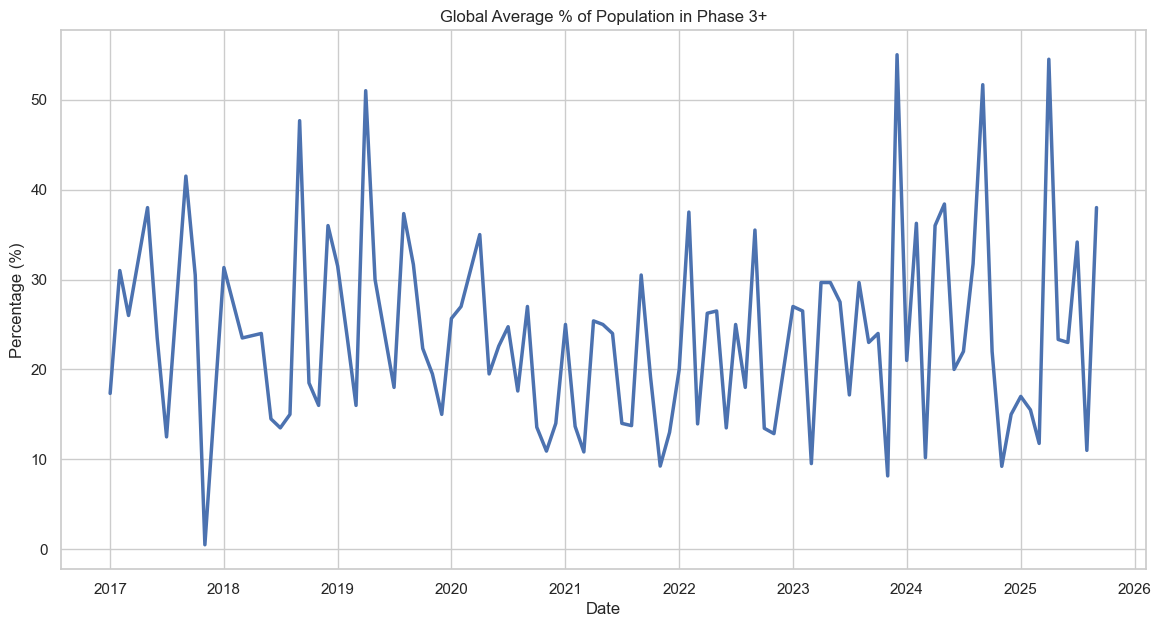

In [6]:
# ============================================================
# QUESTION 1: Global Trend (%)
# ============================================================
global_trend = wide_pct.groupby("date")["crisis_plus_pct"].mean().reset_index()

plt.plot(global_trend["date"], global_trend["crisis_plus_pct"], linewidth=2.5)
plt.title("Global Average % of Population in Phase 3+")
plt.ylabel("Percentage (%)")
plt.xlabel("Date")
plt.show()

## Question 2: Which countries contribute the largest share of the global population in Crisis or worse (IPC Phase ≥ 3)?

### Approach
Using the most recent observation for each country, the number of people classified in IPC Phase 3 or worse was aggregated globally. Each country’s contribution was then expressed as a percentage of the total global Phase 3+ population, and the top contributors were visualized using a horizontal bar chart.

### Findings
The results show that a small number of countries account for a disproportionately large share of the global population facing acute food insecurity. Nigeria and the Democratic Republic of Congo each contribute over 11% of the global Phase 3+ population, followed by Sudan, Yemen, and Ethiopia. This highlights that global food insecurity is highly concentrated, meaning that humanitarian outcomes at the global level are strongly influenced by conditions in a limited set of high-burden countries.

### Recommendations
Given the high concentration of the global Phase 3+ population in a small number of countries, international humanitarian and development efforts should prioritize targeted, country-specific interventions rather than diffuse global responses. Countries such as Nigeria, the Democratic Republic of Congo, and Sudan require sustained multi-sectoral support that combines emergency food assistance with longer-term investments in conflict resolution, climate resilience, and livelihood restoration.

Additionally, global food security monitoring systems should place greater emphasis on high-burden countries, as marginal improvements or deteriorations in these contexts can significantly influence global food insecurity levels. Strengthening early warning systems and coordinated international response mechanisms in these countries could yield outsized global benefits.



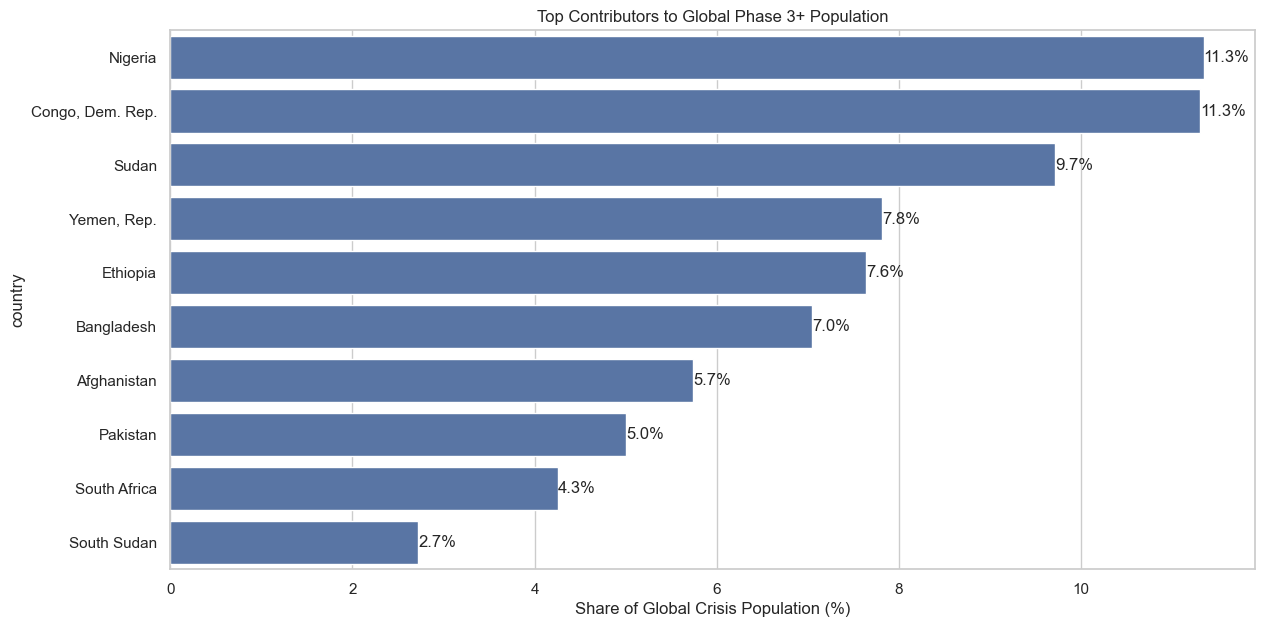

In [9]:
# ============================================================
# QUESTION 2: Global Burden Contribution (People Share)
# ============================================================
latest_people = wide_people.loc[wide_people.groupby("country")["date"].idxmax()]
latest_people["global_share"] = (
    latest_people["crisis_plus_people"] /
    latest_people["crisis_plus_people"].sum()
) * 100

top_burden = latest_people.sort_values("global_share", ascending=False).head(10)

ax = sns.barplot(data=top_burden, y="country", x="global_share")
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.1f}%",
        (p.get_width(), p.get_y() + p.get_height()/2),
        ha="left", va="center"
    )

plt.title("Top Contributors to Global Phase 3+ Population")
plt.xlabel("Share of Global Crisis Population (%)")
plt.show()

## Question 3: Which five countries currently have the highest percentage of their population in Crisis or worse (IPC Phase ≥ 3)?

### Approach
For each country, the most recent available observation was selected. The percentage of the population classified in IPC Phase 3 or worse was computed by summing the shares in Phases 3, 4, and 5. Countries were then ranked by this percentage, and the top five were visualized using a horizontal bar chart.

### Findings
The results indicate extremely high levels of acute food insecurity in a small set of countries. West Bank and Gaza stands out with nearly the entire population classified in Phase 3 or worse, while Haiti, Angola, Yemen, and Uganda all report approximately half of their populations facing crisis-level or more severe food insecurity. These figures reflect widespread and systemic food access challenges rather than localized or temporary shocks.

### Recommendations
In countries where close to half or more of the population is in Phase 3+, humanitarian responses should move beyond short-term emergency food assistance to include large-scale stabilization measures. This includes strengthening social protection systems, restoring food supply chains, and supporting household livelihoods to prevent further deterioration into Emergency or Famine phases.

For contexts with extremely high prevalence, such as West Bank and Gaza, coordinated international action is critical to ensure sustained access to food, protect civilian livelihoods, and prevent long-term nutritional and developmental consequences. Continuous monitoring and rapid-response mechanisms should also be prioritized to track changes in severity and enable timely intervention.


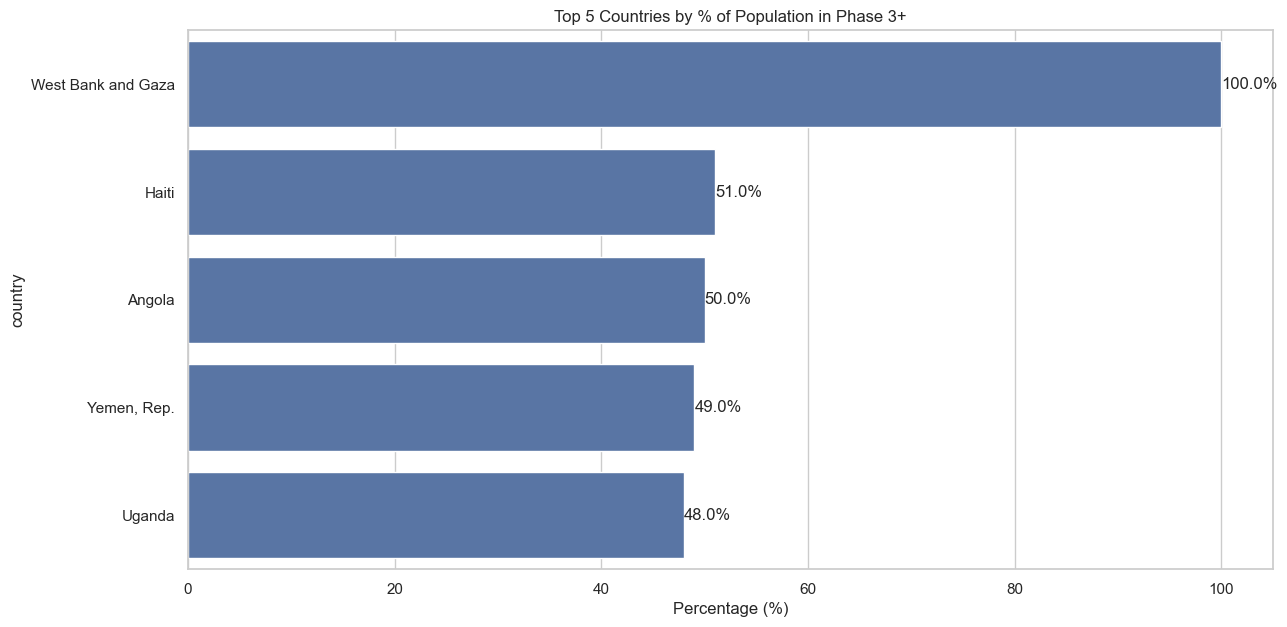

In [10]:
# ============================================================
# QUESTION 3: Top 5 Countries by % Population in Phase 3+ (Latest)
# ============================================================
latest_pct = wide_pct.loc[wide_pct.groupby("country")["date"].idxmax()]
top5_severity = latest_pct.sort_values("crisis_plus_pct", ascending=False).head(5)

ax = sns.barplot(data=top5_severity, y="country", x="crisis_plus_pct")
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.1f}%",
        (p.get_width(), p.get_y() + p.get_height()/2),
        ha="left", va="center"
    )

plt.title("Top 5 Countries by % of Population in Phase 3+")
plt.xlabel("Percentage (%)")
plt.show()

## Question 4: How does food insecurity in West Africa compare to East Africa?

### Approach
Countries were grouped into West Africa and East Africa based on geographic classification. For each region and month, the average percentage of the population in IPC Phase 3 or worse was calculated. A time-series line plot was used to compare trends in acute food insecurity severity between the two regions over time.

### Findings
The results show that East Africa consistently exhibits higher average levels of acute food insecurity compared to West Africa, as well as substantially greater volatility over time. East Africa experiences frequent sharp spikes, indicating repeated shocks or crises, whereas West Africa shows lower average levels with a more stable and gradual pattern. This suggests that food insecurity in East Africa is both more severe and more episodic, while West Africa faces a comparatively persistent but less extreme challenge.

### Recommendations
For East Africa, policy responses should prioritize early warning systems, rapid-response mechanisms, and shock-mitigation strategies, given the high volatility and recurrent spikes in food insecurity severity. Strengthening climate resilience, conflict prevention, and emergency preparedness would be particularly important in reducing sudden deteriorations.

In West Africa, where food insecurity appears more stable but persistent, interventions should focus on structural and long-term solutions, such as improving agricultural productivity, market access, and social protection programs. Region-specific strategies, rather than one-size-fits-all approaches, are essential to effectively address the distinct food insecurity dynamics observed across the two regions.


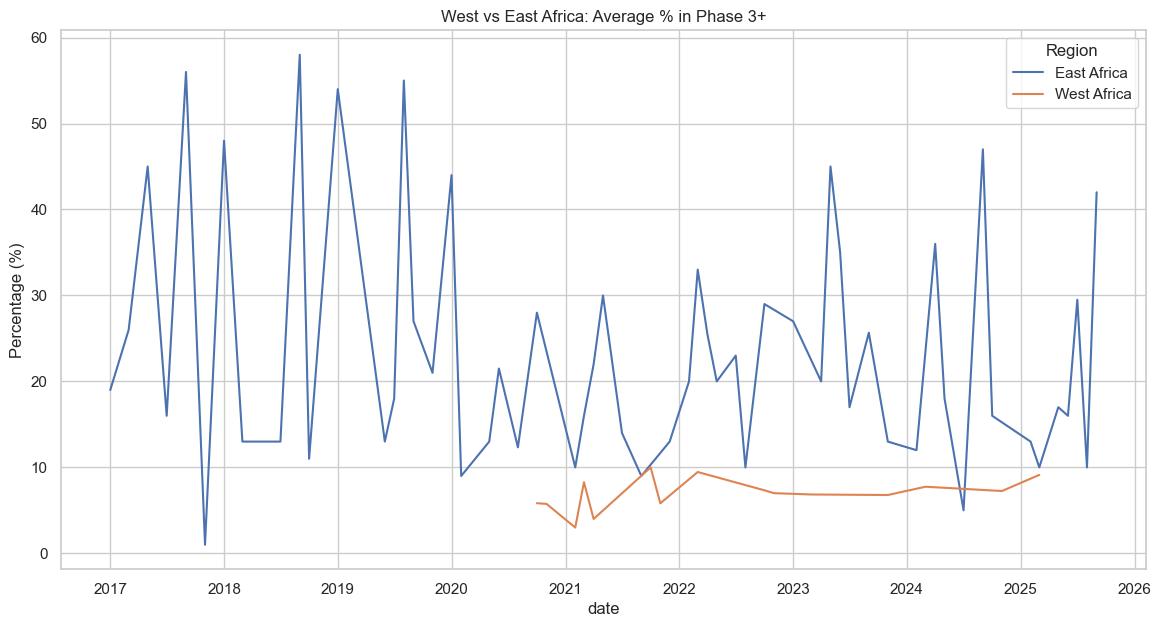

In [11]:
# ============================================================
# QUESTION 4: West vs East Africa (%)
# ============================================================
regional_trend = (
    wide_pct[wide_pct["Region"].isin(["West Africa","East Africa"])]
    .groupby(["Region","date"])["crisis_plus_pct"]
    .mean().reset_index()
)

sns.lineplot(data=regional_trend, x="date", y="crisis_plus_pct", hue="Region")
plt.title("West vs East Africa: Average % in Phase 3+")
plt.ylabel("Percentage (%)")
plt.show()


## Question 5: Among countries in Crisis or worse (IPC Phase ≥ 3), which experience the deepest crises?

### Approach
For each country, the depth of crisis was measured as the proportion of the Phase 3+ population that falls into the most severe categories: Emergency (Phase 4) and Famine/Catastrophe (Phase 5). This severity ratio was averaged over time for each country, and the countries with the highest ratios were visualized using a horizontal bar chart.

### Findings
The results reveal substantial variation in the depth of food insecurity across countries. West Bank and Gaza stands out with over 60% of its Phase 3+ population classified in Phases 4–5, indicating an extremely severe crisis. Other countries such as Angola, Yemen, Haiti, and Pakistan also exhibit high severity ratios, suggesting that a significant share of their food-insecure populations face emergency or catastrophic conditions rather than lower-intensity crisis states.

### Recommendations
In countries with a high Phase 4–5 share, humanitarian responses should prioritize life-saving interventions, including emergency food assistance, nutritional support, and protection of vulnerable populations. These contexts require rapid escalation mechanisms, as small deteriorations can quickly translate into famine-like conditions.

At the same time, policy efforts should focus on preventing populations already in Phase 3 from sliding into Phases 4 and 5 by strengthening early warning systems, ensuring continuity of food supply chains, and maintaining access to essential services. Targeting the depth of crisis, rather than only the size of the affected population, is critical for reducing mortality and long-term human capital losses.


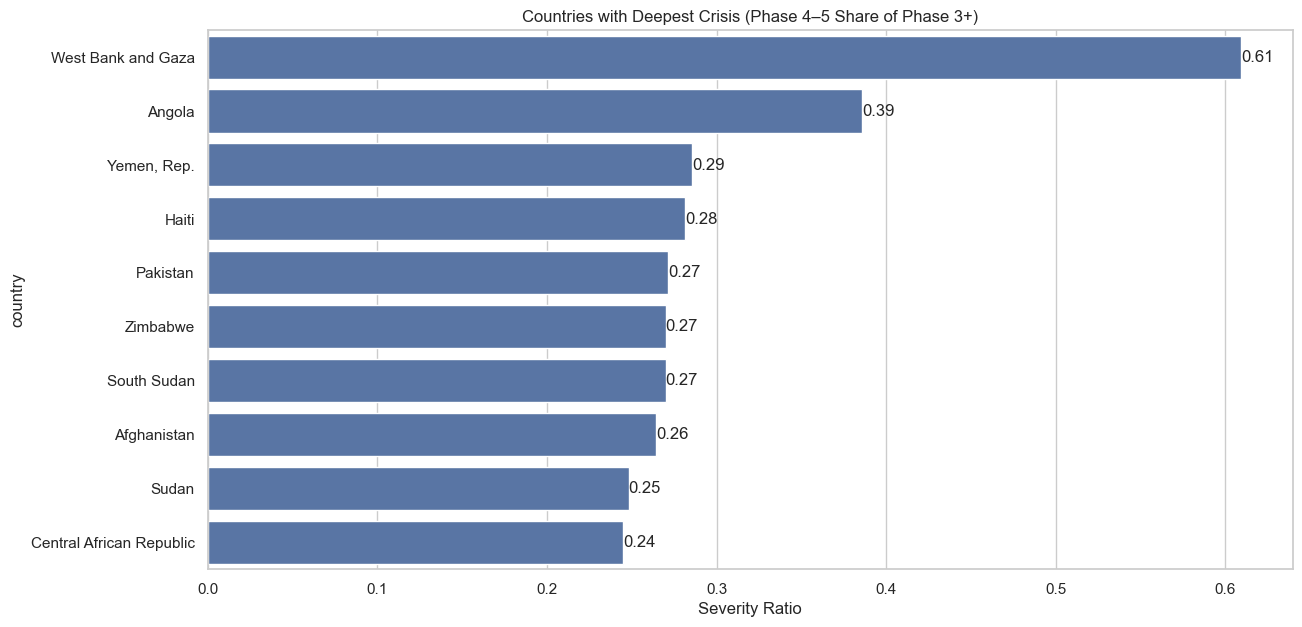

In [12]:
# ============================================================
# QUESTION 5: Depth of Crisis (Phase 4–5 Share)
# ============================================================
wide_pct["severe_share"] = (
    wide_pct[["phase_4_pct","phase_5_pct"]].sum(axis=1) /
    wide_pct["crisis_plus_pct"]
)

depth = (
    wide_pct.groupby("country")["severe_share"]
    .mean()
    .reset_index()
    .sort_values("severe_share", ascending=False)
    .head(10)
)

ax = sns.barplot(data=depth, y="country", x="severe_share")
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.2f}",
        (p.get_width(), p.get_y() + p.get_height()/2),
        ha="left", va="center"
    )

plt.title("Countries with Deepest Crisis (Phase 4–5 Share of Phase 3+)")
plt.xlabel("Severity Ratio")
plt.show()

## Question 6: Which countries are experiencing the fastest deterioration in food insecurity severity?

### Approach
For each country with sufficient time-series observations, a linear regression was fitted to the percentage of the population in IPC Phase 3 or worse over time. The slope of the regression line was used as an indicator of the rate of change in food insecurity severity, with higher positive slopes indicating faster deterioration. Countries were ranked by their slope values and the top ten were visualized.

### Findings
The results indicate that Haiti is experiencing the most rapid deterioration in food insecurity severity, followed by Uganda and Namibia. These countries show strong upward trends in the share of their populations facing crisis-level or worse food insecurity. The presence of several Sub-Saharan African countries among the fastest deteriorating cases suggests that emerging or escalating crises may not yet be fully captured by static severity rankings.

### Recommendations
Countries exhibiting rapid deterioration should be prioritized for preventive and anticipatory interventions, even if their current severity levels are not the highest globally. Early action—such as scaling up food assistance, supporting agricultural inputs, and strengthening social safety nets—can help prevent these upward trends from translating into deeper humanitarian crises.

In addition, continuous monitoring of trend indicators, rather than relying solely on snapshot severity measures, is essential for timely policy responses. Integrating trend-based early warning signals into food security surveillance systems could significantly improve crisis preparedness and response.


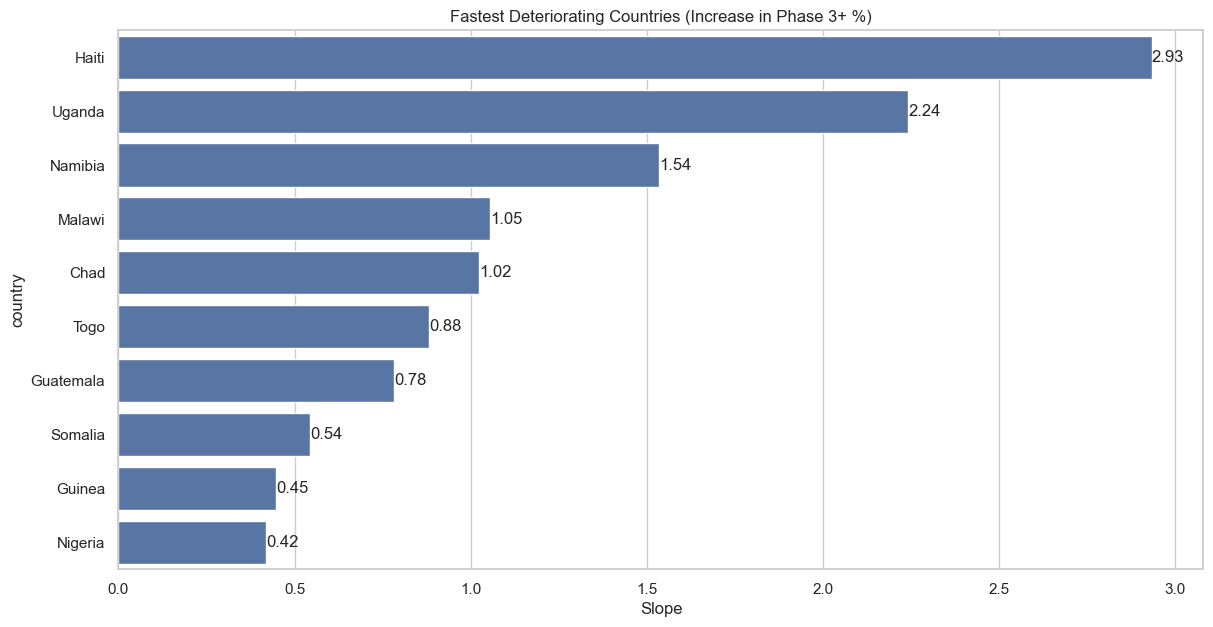

In [13]:
# ============================================================
# QUESTION 6: Fastest Deterioration (% Slope)
# ============================================================
slopes = []

for country, grp in wide_pct.groupby("country"):
    if len(grp) > 6:
        grp = grp.sort_values("date")
        X = np.arange(len(grp)).reshape(-1,1)
        y = grp["crisis_plus_pct"].values
        slope = LinearRegression().fit(X, y).coef_[0]
        slopes.append((country, slope))

slope_df = pd.DataFrame(slopes, columns=["country","slope"])
fastest = slope_df.sort_values("slope", ascending=False).head(10)

ax = sns.barplot(data=fastest, y="country", x="slope")
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.2f}",
        (p.get_width(), p.get_y() + p.get_height()/2),
        ha="left", va="center"
    )

plt.title("Fastest Deteriorating Countries (Increase in Phase 3+ %)")
plt.xlabel("Slope")
plt.show()


## Question 7: Is higher food insecurity severity associated with greater volatility?

### Approach
For each country, the average percentage of the population in IPC Phase 3 or worse was calculated across the available time period, along with the standard deviation of that percentage as a measure of volatility. A scatter plot was used to visualize the relationship between average severity and volatility, and a Pearson correlation coefficient was computed to quantify the strength of the association.

### Findings
The plot suggests a positive relationship between average severity and volatility in food insecurity. Countries with higher mean levels of Phase 3+ tend to also exhibit greater fluctuations over time, indicating that severe food insecurity is often accompanied by instability rather than persistence at a constant level. However, the dispersion of points shows that this relationship is not perfectly linear, suggesting heterogeneity in how different countries experience and manage food insecurity shocks.

### Recommendations
Policymakers and humanitarian actors should recognize that high-severity contexts are frequently unstable and prone to sudden changes. In such settings, interventions should be designed to be flexible and scalable, allowing rapid adjustment in response to worsening conditions.

At the same time, countries with moderate average severity but high volatility should not be overlooked, as sharp fluctuations may signal vulnerability to external shocks. Incorporating volatility metrics alongside average severity in food security assessments can improve early warning systems and lead to more adaptive and resilient policy responses.


Correlation between severity and volatility: r=nan, p=nan


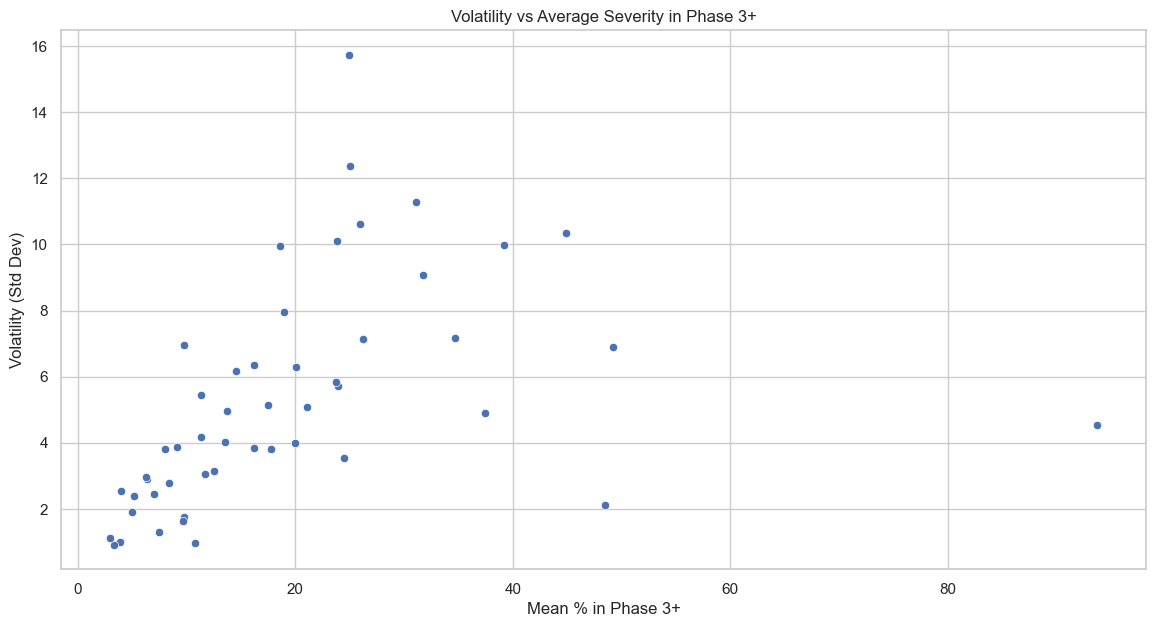

In [ ]:
# ============================================================
# QUESTION 7: Volatility vs Severity
# ============================================================
stats = wide_pct.groupby("country")["crisis_plus_pct"].agg(["mean","std"]).reset_index()
corr, p_corr = pearsonr(stats["mean"], stats["std"])

print(f"Correlation between severity and volatility: r={corr:.2f}, p={p_corr:.5f}")

sns.scatterplot(data=stats, x="mean", y="std")
plt.title("Volatility vs Average Severity in Phase 3+")
plt.xlabel("Mean % in Phase 3+")
plt.ylabel("Volatility (Std Dev)")
plt.show()


## Question 8: Which countries show evidence of recovery versus persistent food insecurity?

### Approach
For each country with sufficient time-series data, a linear regression was fitted to the percentage of the population in IPC Phase 3 or worse over time. The slope of the regression line was used to indicate the direction and magnitude of change. Negative slopes suggest a declining share of the population in Phase 3+, which is interpreted as a signal of recovery or improvement in food security conditions.

### Findings
The results indicate that countries such as Pakistan and Madagascar exhibit the strongest signs of recovery, with substantial declines in the percentage of their populations facing crisis-level or worse food insecurity. Other countries, including Sierra Leone, Burundi, and Guinea-Bissau, also show moderate downward trends. While these patterns suggest improving conditions, the relatively small slopes for some countries indicate that recovery may be gradual and potentially fragile.

### Recommendations
For countries showing signs of recovery, policy efforts should focus on sustaining gains by strengthening food systems, social protection programs, and economic resilience. Preventing relapse into higher levels of food insecurity is critical, particularly in contexts where improvements may be driven by temporary factors.

At the same time, continued monitoring is essential to ensure that observed declines represent genuine structural improvements rather than short-term fluctuations. Integrating recovery indicators with volatility and severity metrics can help policymakers distinguish durable progress from temporary relief and design more effective long-term interventions.


In [15]:
# ============================================================
# QUESTION 8: Recovery vs Persistence
# ============================================================
recovery = slope_df.sort_values("slope").head(10)

print("\nCountries Showing Strongest Recovery (Declining Phase 3+ %):")
print(recovery)


Countries Showing Strongest Recovery (Declining Phase 3+ %):
                     country     slope
26                  Pakistan -2.950000
18                Madagascar -1.203431
28              Sierra Leone -0.321212
3                    Burundi -0.310714
13             Guinea-Bissau -0.254545
33               Yemen, Rep. -0.250000
2               Burkina Faso -0.214286
5   Central African Republic -0.150350
16                     Kenya -0.126374
0                Afghanistan -0.030882
